# Autocircuit Test

In [36]:
%load_ext autoreload
%autoreload 2

import torch as t

from auto_circuit.data import load_datasets_from_json
from auto_circuit.experiment_utils import load_tl_model
from auto_circuit.types import AblationType
from auto_circuit.utils.ablation_activations import src_ablations
from auto_circuit.utils.graph_utils import patch_mode, patchable_model
from auto_circuit.utils.misc import repo_path_to_abs_path
from auto_circuit.visualize import draw_seq_graph

from utils.circuit_discovery import acdc_discovery
from utils.compatibility import convert_model_to_hooked_transformer

from model.gpt_neo import GPTNeoWithSelfAblation
from model.config import GPTNeoWithSelfAblationConfig

from os.path import abspath
from pathlib import Path
import tiktoken

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = load_tl_model("tiny-stories-1M", device) # Smaller model for now

Device: cuda
Loaded pretrained model tiny-stories-1M into HookedTransformer


/home/jazhyc/miniconda3/envs/ablation/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [42]:
path = Path("datasets/autocircuit_ioi_prompts.json")
train_loader, test_loader = load_datasets_from_json(
    model=model,
    path=path,
    device=device,
    prepend_bos=True,
    batch_size=64,
    train_test_size=(128, 128),
)


## Testing autocircuit's ACDC using regular transformer

In [43]:
def test_model(patched_model, data_loader, save_path=None):
    total_edges, remaining_edges, pruned_scores = acdc_discovery(patched_model, data_loader)
    print(f"Total edges: {total_edges}")
    print(f"Remaining edges: {remaining_edges}")
    
    # Pruned neurons are given a value of inf
    # Interative Image may cause performance issues
    if save_path:
        save_path = Path(save_path).resolve()

    _ = draw_seq_graph(patched_model, pruned_scores, score_threshold=0.1, orientation='v', layer_spacing='True', file_path=save_path)
    
    return remaining_edges, pruned_scores

In [44]:
patched_model = patchable_model(
    model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True,
    device=device,
)

In [ ]:
regular_remaining_edges, regular_pruned_scores = test_model(patched_model, train_loader, save_path="plots/base2.svg")

Total edges: 23981
Remaining edges: 215


## Testing ACDC using ablated transformer

In [45]:
# load ablated model

#TODO: Put this code in a separate file
model_path = "model_weights/fanciful-fog-78.pt"
model_specific_config = {
    'hidden_size': 128,
    'max_position_embeddings': 256,
    
    # These two are currently not mutually exclusive
    'has_layer_by_layer_ablation_mask': False,
    'has_overall_ablation_mask': True,
}

model_config = GPTNeoWithSelfAblationConfig(**model_specific_config)
model = GPTNeoWithSelfAblation(model_config).to(device)
tokenizer = tiktoken.get_encoding("gpt2")
model.load_state_dict(t.load(model_path, map_location=device))
model.eval()

/tmp/ipykernel_1265/4023009734.py:17: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



GPTNeoWithSelfAblation(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(256, 128)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlockWithSelfAblation(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): AttentionWithSelfAblation(
          (k_hook): HookPoint()
          (v_hook): HookPoint()
          (q_hook): HookPoint()
          (attn_hook): HookPoint()
          (context_hook): HookPoint()
          (ablated_context_hook): HookPoint()
          (attention): ModuleDict(
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLPWithSelfAblation(
          (c_fc): Li

In [46]:
hooked_ablated_model = convert_model_to_hooked_transformer(model)

# Requirements mentioned in load_tl_model
hooked_ablated_model.cfg.use_attn_result = True
hooked_ablated_model.cfg.use_attn_in = True
hooked_ablated_model.cfg.use_split_qkv_input = True
hooked_ablated_model.cfg.use_hook_mlp_in = True
hooked_ablated_model.eval()
for param in hooked_ablated_model.parameters():
    param.requires_grad = False

/home/jazhyc/miniconda3/envs/ablation/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [47]:
patched_ablated_model = patchable_model(hooked_ablated_model, factorized=True, slice_output="last_seq", separate_qkv=True, device=device)

In [48]:
ablated_remaining_edges, ablated_pruned_scores = test_model(patched_ablated_model, train_loader, save_path="plots/fanciful-fog2.svg")

Total edges: 23981
Remaining edges: 51


In [51]:
data = {
    'Base Model': {
        'edges': regular_remaining_edges,
        'path': 'plots/base1.png',
    },
    'Ablated Model': {
        'edges': ablated_remaining_edges,
        'path': 'plots/fanciful-fog1.png',
    }
}

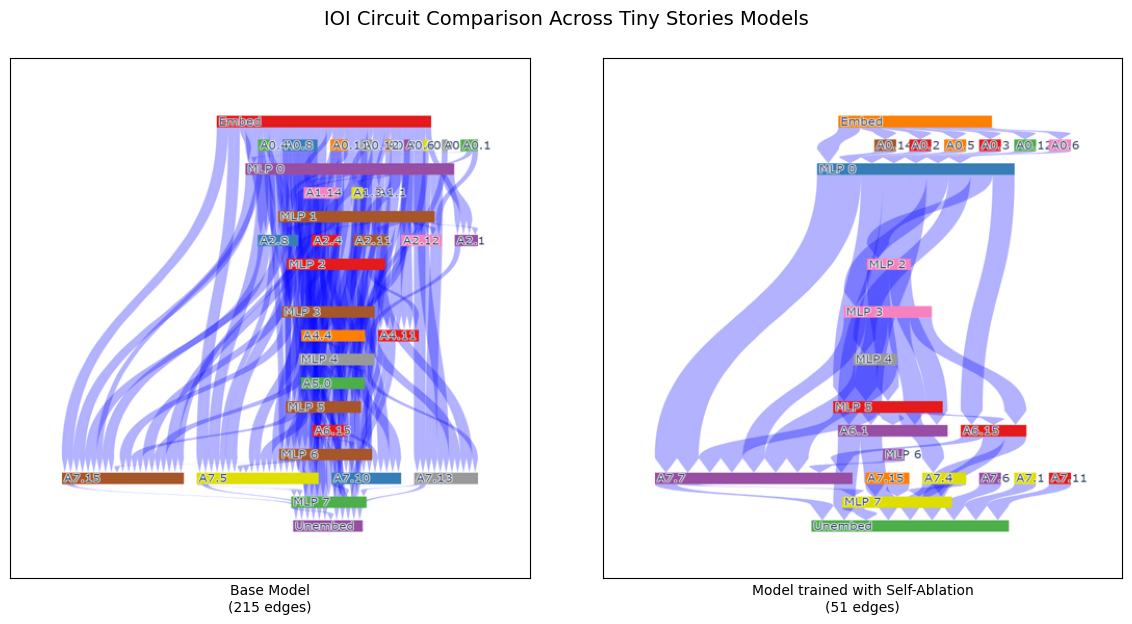

In [52]:
import matplotlib.pyplot as plt
from PIL import Image

# Load images
base_img = Image.open(data['Base Model']['path'])
ablated_img = Image.open(data['Ablated Model']['path'])

# Resize to same dimensions
target_size = (500, 500)
base_img_resized = base_img.resize(target_size)
ablated_img_resized = ablated_img.resize(target_size)

# Create figure and subplots with top padding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot images with captions at bottom
ax1.imshow(base_img_resized)
ax1.set_xlabel(f'Base Model\n({data["Base Model"]["edges"]} edges)')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(ablated_img_resized)
ax2.set_xlabel(f'Model trained with Self-Ablation\n({data["Ablated Model"]["edges"]} edges)')
ax2.set_xticks([])
ax2.set_yticks([])

# Set overall title higher
fig.suptitle('IOI Circuit Comparison Across Tiny Stories Models', fontsize=14, y=1)

# Adjust layout
plt.tight_layout()
plt.show()